## Game Review Sentiment Analysis
Video: https://www.youtube.com/watch?v=si8zZHkufRY

In this assignment we are going to use tflearn in order to perform sentiment analysis on the [IGN game review](https://www.kaggle.com/egrinstein/20-years-of-games) dataset form Kaggle

Let's start by importing our dependencies

In [1]:
import pandas as pd
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import calendar
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

hdf5 not supported (please install/reinstall h5py)


/Users/nickrobinson/anaconda3/envs/neural/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


We now need to read in the IGN dataset using pandas. We will then take a peak at the first 10 rows in the dataset

In [2]:
df = pd.read_csv('ign.csv')
df.head(10)

,Unnamed: 0,score_phrase,title,url,platform,score,genre,editors_choice,release_year,release_month,release_day
0,0,Amazing,LittleBigPlanet PS Vita,/games/littlebigplanet-vita/vita-98907,PlayStation Vita,9.0,Platformer,Y,2012,9,12
1,1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,/games/littlebigplanet-ps-vita-marvel-super-he...,PlayStation Vita,9.0,Platformer,Y,2012,9,12
2,2,Great,Splice: Tree of Life,/games/splice/ipad-141070,iPad,8.5,Puzzle,N,2012,9,12
3,3,Great,NHL 13,/games/nhl-13/xbox-360-128182,Xbox 360,8.5,Sports,N,2012,9,11
4,4,Great,NHL 13,/games/nhl-13/ps3-128181,PlayStation 3,8.5,Sports,N,2012,9,11
5,5,Good,Total War Battles: Shogun,/games/total-war-battles-shogun/mac-142565,Macintosh,7.0,Strategy,N,2012,9,11
6,6,Awful,Double Dragon: Neon,/games/double-dragon-neon/xbox-360-131320,Xbox 360,3.0,Fighting,N,2012,9,11
7,7,Amazing,Guild Wars 2,/games/guild-wars-2/pc-896298,PC,9.0,RPG,Y,2012,9,11
8,8,Awful,Double Dragon: Neon,/games/double-dragon-neon/ps3-131321,PlayStation 3,3.0,Fighting,N,2012,9,11
9,9,Good,Total War Battles: Shogun,/games/total-war-battles-shogun/pc-142564,PC,7.0,Strategy,N,2012,9,11


## Clean our data

In [3]:
def clean_str(string):
    """
    Tokenization/string cleaning.
    """
    string = re.sub(r"[^A-Za-z0-9(),:!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r":", " : ", string)
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)
    string = string.strip().lower()
    string = re.sub(r"[0-9]{2,}", "NUM", string)
    return string


#Convert editors_choice
df['editors_choice'] = df['editors_choice'].apply(lambda x: 'editors_choice' if x == 'Y' else '')
df['editors_choice'].head(10)

#Convert Platform
df['platform'] = df['platform'].apply(lambda x: x.lower().replace(" ", "_"))
df['platform'].head(10)

#Convert Release Month
months = ['janurary', 'feburary', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
df['release_month'] = df['release_month'].apply(lambda x: calendar.month_abbr[x])

#Convert Sentiment
positive_sentiment = ['amazing', 'great', 'good']
negative_sentiment = ['mediocre', 'painful', 'awful']

#Clean up the titles
df['cleaned_title'] = df['title'].apply(clean_str)

df['sentiment'] = df['score_phrase'].apply(lambda x: 1 if x.lower() in positive_sentiment else 0)

df = df[['sentiment', 'cleaned_title']]
df.head(10)


,sentiment,cleaned_title
0,1,littlebigplanet ps vita
1,1,littlebigplanet ps vita marvel super hero edition
2,1,splice : tree of life
3,1,nhl NUM
4,1,nhl NUM
5,1,total war battles : shogun
6,0,double dragon : neon
7,1,guild wars 2
8,0,double dragon : neon
9,1,total war battles : shogun


### Visualize distributions

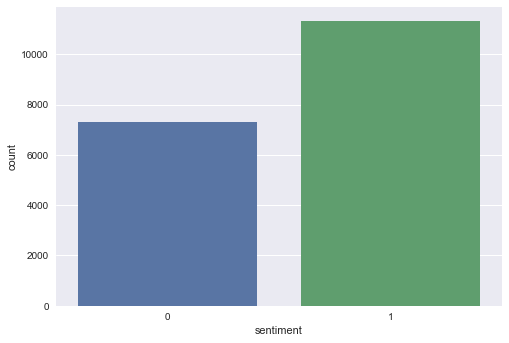

In [4]:
sns.set(style="darkgrid")

# Plotting
sns.countplot(x='sentiment', data=df)
sns.plt.show()

In [5]:
# Instantiate an CountVectorizer object removing english stop words. Set lowercase false cause I've have done this
# and I wanna keep NUM token in uppercase.
vectorizer = CountVectorizer(stop_words='english', lowercase=False)

# Fit the data 
titles_vectorized = vectorizer.fit(df['cleaned_title'])

# Get the vocabulary
vocabulary = titles_vectorized.vocabulary_

words = set(vocabulary.keys())

# Size of vocabulary
size_vocab = len(vocabulary)
print "The vocabulary has {} words".format(size_vocab)

The vocabulary has 7572 words


In [6]:
# Instantiate an CountVectorizer object removing english stop words. Set lowercase false cause I've have done this
# and I wanna keep NUM token in uppercase.
vectorizer = CountVectorizer(stop_words='english', lowercase=False)

# Fit the data 
test = vectorizer.fit_transform(df['cleaned_title'])

X = []
max_len = 0
for x in test.toarray():
    X.append(np.nonzero(x)[0].tolist())
    max_len = len(np.nonzero(x)[0]) if len(np.nonzero(x)[0]) > max_len else max_len
    
Y = df['sentiment']
print Y

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=7)

print max_len


0        1
1        1
2        1
3        1
4        1
5        1
6        0
7        1
8        0
9        1
10       1
11       1
12       1
13       1
14       1
15       0
16       0
17       1
18       0
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       0
        ..
18595    0
18596    0
18597    0
18598    0
18599    1
18600    1
18601    1
18602    1
18603    1
18604    1
18605    0
18606    0
18607    1
18608    0
18609    1
18610    0
18611    0
18612    1
18613    1
18614    1
18615    1
18616    1
18617    1
18618    1
18619    1
18620    1
18621    1
18622    0
18623    0
18624    0
Name: sentiment, dtype: int64
11


## Tensorflow 
### Data Preprocessing

In [7]:
# Sequence padding
trainX = pad_sequences(X_train, maxlen=max_len, value=0.)
testX = pad_sequences(X_test, maxlen=max_len, value=0.)

# Converting labels to binary vectors
trainY = to_categorical(Y_train, nb_classes=2)
testY = to_categorical(Y_test, nb_classes=2)

### Build out our network

In [8]:
# Network building
net = tflearn.input_data([None, max_len])
net = tflearn.embedding(net, input_dim=size_vocab, output_dim=200)
net = tflearn.lstm(net, 200, dropout=0.8, bias=True)
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy')

### Training time

In [ ]:
# Training
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainX, trainY, validation_set=(testX, testY), show_metric=True, batch_size=32)

Training Step: 1437  | total loss: 0.37795
| Adam | epoch: 003 | loss: 0.37795 - acc: 0.8409 -- iter: 06816/13037


## Experiments
### Try RELU as activation function


In [ ]:
# Network building
net = None
net = tflearn.input_data([None, max_len])
net = tflearn.embedding(net, input_dim=size_vocab, output_dim=128)
net = tflearn.lstm(net, 128, dropout=0.8, bias=True)
net = tflearn.fully_connected(net, 2, activation='relu')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001, loss='categorical_crossentropy')
                         
# Training
model = None
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainX, trainY, validation_set=(testX, testY), show_metric=True, batch_size=32)